In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from datetime import datetime
import glob
import re
import os
import io
from scipy.stats import boxcox

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_ = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="",
    config=Config(signature_version='oauth'),
    endpoint_url='')

body = client_.get_object(Bucket='',Key='US_Accidents_June20.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


In [55]:
df = df_data_1

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3513617 entries, 0 to 3513616
Data columns (total 50 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 int64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        datetime64[ns]
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)          

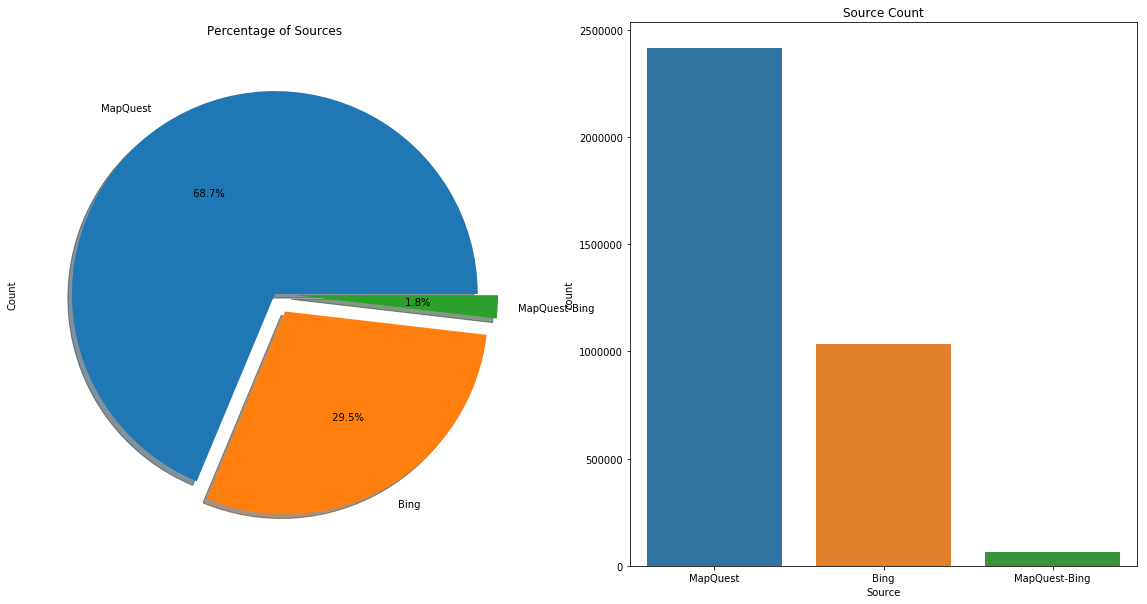

In [57]:
f,ax = plt.subplots(1,2,figsize = (20,10))
df['Source'].value_counts().plot.pie(explode = [0,0.1,0.1],autopct =' %1.1f%%',ax = ax[0],shadow = True)
ax[0].set_title('Percentage of Sources')
ax[0].set_ylabel('Count')
sns.countplot('Source',data = df,ax = ax[1],order = df['Source'].value_counts().index)
ax[1].set_title('Source Count')
plt.show()

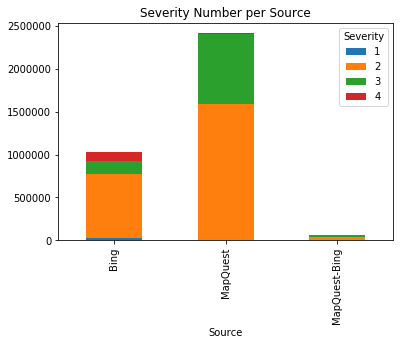

In [58]:
df_source = df.groupby(['Severity','Source']).size().reset_index().pivot(\
    columns = 'Severity', index='Source', values = 0)
df_source.plot(kind = 'bar', stacked = True, title = 'Severity Number per Source')

In [59]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])
df['Duration'] = df.End_Time - df.Start_Time 
df['Duration'] = df['Duration'].apply(lambda x:round(x.total_seconds() / 60) )

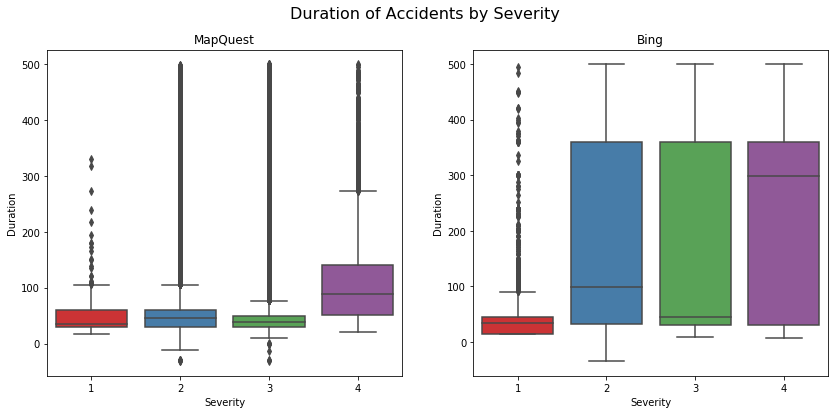

In [60]:
fig, axs = plt.subplots(ncols = 2, figsize = (14,6))
sns.boxplot(x = "Severity", y = "Duration", data = df.loc[(df['Source'] == "MapQuest") & (df['Duration'] < 500),], palette = "Set1", ax = axs[0])
axs[0].set_title('MapQuest')
fig.suptitle('Duration of Accidents by Severity', fontsize=16)
sns.boxplot(x = "Severity", y = "Duration", data = df.loc[(df['Source'] == "Bing") & (df['Duration'] < 500),], palette = "Set1", ax = axs[1])
axs[1].set_title('Bing')
plt.show()

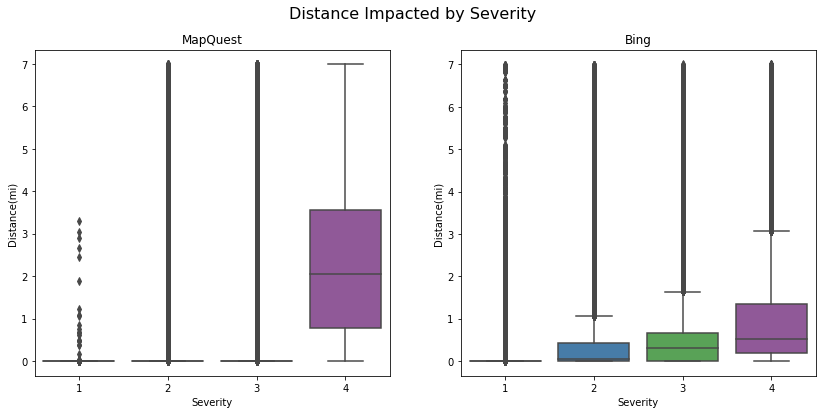

In [61]:
fig, axs = plt.subplots(ncols = 2, figsize = (14, 6))
sns.boxplot(x = "Severity", y = "Distance(mi)", data = df.loc[(df['Source'] == "MapQuest") & (df['Distance(mi)'] < 7),], palette = "Set1", ax = axs[0])
axs[0].set_title('MapQuest')
fig.suptitle('Distance Impacted by Severity', fontsize=16)
sns.boxplot(x = "Severity", y = "Distance(mi)", data = df.loc[(df['Source'] == "Bing") & (df['Distance(mi)'] < 7),], palette = "Set1", ax = axs[1])
axs[1].set_title('Bing')
plt.show()

In [62]:
df = df.loc[df['Source'] == "MapQuest"]
df = df.drop(['Source'], axis = 1)

In [63]:
df = df.drop(['ID', 'TMC', 'Description', 'Country', 'Turning_Loop', 'Distance(mi)', 'End_Time', 'Duration', 'End_Lat', 'End_Lng', 'Weather_Timestamp'], axis = 1)

In [64]:
print("Wind Direction: ", df['Wind_Direction'].unique())

Wind Direction:  ['Calm' 'SW' 'SSW' 'WSW' 'WNW' 'NW' 'West' 'NNW' 'NNE' 'South' 'North'
 'Variable' 'SE' 'SSE' 'ESE' 'East' 'NE' 'ENE' 'E' 'W' nan 'S' 'VAR'
 'CALM' 'N']


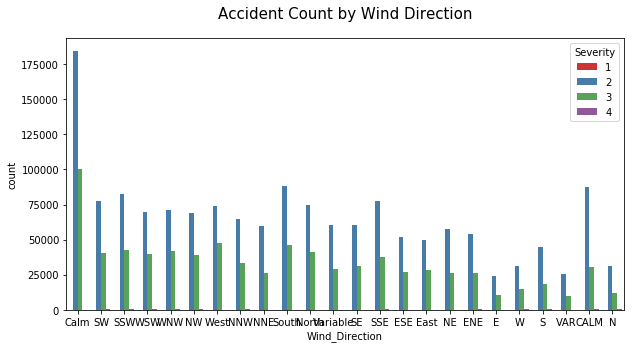

In [65]:
plt.figure(figsize=(10,5))
chart = sns.countplot(x='Wind_Direction', hue='Severity', data=df ,palette="Set1")
plt.title("Accident Count by Wind Direction", size=15, y=1.05)
plt.show()

In [66]:
df= df.drop(['Wind_Direction'], axis =1)

In [67]:
df['Weather_Condition'] = df['Weather_Condition'].fillna('Clear')

In [68]:
df['Year'] = df['Start_Time'].dt.year
nmonth = df['Start_Time'].dt.month
df['Month'] = nmonth
df['Weekday'] = df['Start_Time'].dt.weekday
days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in nmonth.values]
nday = nday + df["Start_Time"].dt.day.values
df['Day'] = nday
df['Weekday'] = df['Start_Time'].dt.weekday
df['Hour'] = df['Start_Time'].dt.hour

df['Minute'] = df['Hour'] * 60.0 + df["Start_Time"].dt.minute

df.loc[:10,['Start_Time', 'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']]

,Start_Time,Year,Month,Weekday,Day,Hour,Minute
0,2016-02-08 05:46:00,2016,2,0,39,5,346.0
1,2016-02-08 06:07:59,2016,2,0,39,6,367.0
2,2016-02-08 06:49:27,2016,2,0,39,6,409.0
3,2016-02-08 07:23:34,2016,2,0,39,7,443.0
4,2016-02-08 07:39:07,2016,2,0,39,7,459.0
5,2016-02-08 07:44:26,2016,2,0,39,7,464.0
6,2016-02-08 07:59:35,2016,2,0,39,7,479.0
7,2016-02-08 07:59:58,2016,2,0,39,7,479.0
8,2016-02-08 08:00:40,2016,2,0,39,8,480.0
9,2016-02-08 08:10:04,2016,2,0,39,8,490.0


In [69]:
missing = pd.DataFrame(df.isnull().sum()).reset_index()
missing.columns = ['Feature','Percent_Missing(%)']
missing['Percent_Missing(%)'] = missing['Percent_Missing(%)'].apply(lambda x : x / df.shape[0] * 100)
missing.loc[missing['Percent_Missing(%)'] > 0, : ]

,Feature,Percent_Missing(%)
4,Number,59.879195
7,City,0.002071
10,Zipcode,0.012840
11,Timezone,0.085366
12,Airport_Code,0.170857
13,Temperature(F),1.634138
14,Wind_Chill(F),58.718072
15,Humidity(%),1.742119
16,Pressure(in),1.404009
17,Visibility(mi),1.969680


In [70]:
display(df[["Humidity(%)","Pressure(in)","Wind_Speed(mph)","Precipitation(in)"]].describe())

,Humidity(%),Pressure(in),Wind_Speed(mph),Precipitation(in)
count,2.372241e+06,2.380404e+06,2.076023e+06,895528.000000
mean,6.624201e+01,2.981517e+01,8.252023e+00,0.018233
std,2.233322e+01,7.047187e-01,5.104554e+00,0.205441
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,5.000000e+01,2.979000e+01,5.000000e+00,0.000000
50%,6.900000e+01,2.997000e+01,7.000000e+00,0.000000
75%,8.500000e+01,3.011000e+01,1.040000e+01,0.000000
max,1.000000e+02,3.304000e+01,8.228000e+02,25.000000


In [71]:
WD=['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']
print("Missing Counts: ")
for i in WD:
    df[i] = df.groupby(['Airport_Code', 'Month'])[i].apply(lambda x: x.fillna(x.median()))
print( i + " : " + df[i].isnull().sum().astype(str))

Missing Counts: 
Wind_Speed(mph) : 15382


In [72]:
df = df.dropna(subset=WD)

In [73]:
df = df.drop(['Number', 'Wind_Chill(F)', 'Precipitation(in)'], axis = 1)

In [74]:
df = df.dropna(subset = ['City', 'Zipcode', 'Airport_Code', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Wind_Speed(mph)'])

In [75]:
def visualize_severity_detailed(df,column_name,decending_order = True):
    
    unique_types = np.sort(df[column_name].unique())
    unique_details = {'Severity 1':[],'Severity 2':[],'Severity 3':[],'Severity 4':[],'Total':[]}

    for arg in unique_types:
        dmo = df[df[column_name] == arg]

        unique_details['Total'].append(dmo.shape[0])
        unique_details['Severity 1'].append(dmo[dmo['Severity'] == 1].shape[0])
        unique_details['Severity 2'].append(dmo[dmo['Severity'] == 2].shape[0])
        unique_details['Severity 3'].append(dmo[dmo['Severity'] == 3].shape[0])
        unique_details['Severity 4'].append(dmo[dmo['Severity'] == 4].shape[0])

    unique_details['Total'] = np.asarray(unique_details['Total'])
    unique_details['Severity 1'] = np.asarray(unique_details['Severity 1'])
    unique_details['Severity 2'] = np.asarray(unique_details['Severity 2'])
    unique_details['Severity 3'] = np.asarray(unique_details['Severity 3'])
    unique_details['Severity 4'] = np.asarray(unique_details['Severity 4'])
    
    if decending_order:

        ind = np.argsort(unique_details['Total'])
        ind = np.flip(ind)

        unique_types = unique_types[list(ind)]
        unique_details['Total'] = unique_details['Total'][ind]
        unique_details['Severity 1'] = unique_details['Severity 1'][ind]
        unique_details['Severity 2'] = unique_details['Severity 2'][ind]
        unique_details['Severity 3'] = unique_details['Severity 3'][ind]
        unique_details['Severity 4'] = unique_details['Severity 4'][ind]    

    frame = pd.DataFrame(unique_details,index = unique_types)
    display(frame)
    
    return unique_types,unique_details

source_types, source_details = visualize_severity_detailed(df, column_name = 'Severity')

,Severity 1,Severity 2,Severity 3,Severity 4,Total
2,0,1586414,0,0,1586414
3,0,0,804436,0,804436
4,0,0,0,6656,6656
1,1043,0,0,0,1043


In [76]:
state_names = list(df['State'].unique())

state_details = {'Total':[],'Severity(%) 1':[],'Severity(%) 2':[],
               'Severity(%) 3':[],'Severity(%) 4':[]}

for state in state_names:
    dmo = df[df['State'] == state]
    tot_acci = dmo.shape[0]
    
    state_details['Total'].append(tot_acci)
    
    sev_cnt = dmo[dmo['Severity'] == 1].shape[0]        
    state_details['Severity(%) 1'].append(sev_cnt / tot_acci * 100)

    sev_cnt = dmo[dmo['Severity'] == 2].shape[0]        
    state_details["Severity(%) 2"].append(sev_cnt / tot_acci * 100)
    
    sev_cnt = dmo[dmo['Severity'] == 3].shape[0]        
    state_details['Severity(%) 3'].append(sev_cnt / tot_acci * 100)

    sev_cnt = dmo[dmo['Severity'] == 4].shape[0]        
    state_details['Severity(%) 4'].append(sev_cnt / tot_acci * 100)

print("Accident count per sate and severity percentage per state")
frame = pd.DataFrame(state_details,index = state_names)
display(frame)

Accident count per sate and severity percentage per state


,Total,Severity(%) 1,Severity(%) 2,Severity(%) 3,Severity(%) 4
OH,45205,0.037606,62.603694,36.927331,0.431368
WV,321,0.311526,22.118380,59.501558,18.068536
CA,441544,0.056846,57.394960,42.453074,0.095121
FL,191768,0.040674,64.252639,35.249885,0.456802
GA,68571,0.042292,41.233174,57.670152,1.054382
SC,161897,0.030884,79.337480,20.451275,0.180362
NE,21951,0.054667,84.442622,15.461710,0.041000
IA,8660,0.034642,41.951501,57.344111,0.669746
IL,58491,0.027355,80.085825,19.573952,0.312869
MO,20114,0.039773,29.715621,69.309933,0.934672


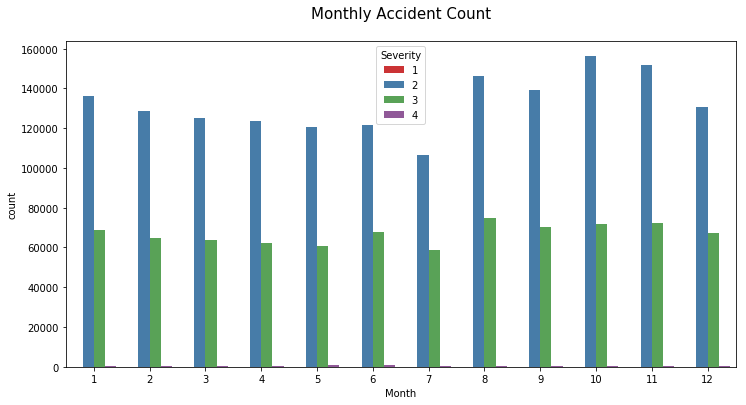

In [77]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'Month', hue ='Severity', data = df ,palette = "Set1")
plt.title('Monthly Accident Count', size = 15, y = 1.05)
plt.show()

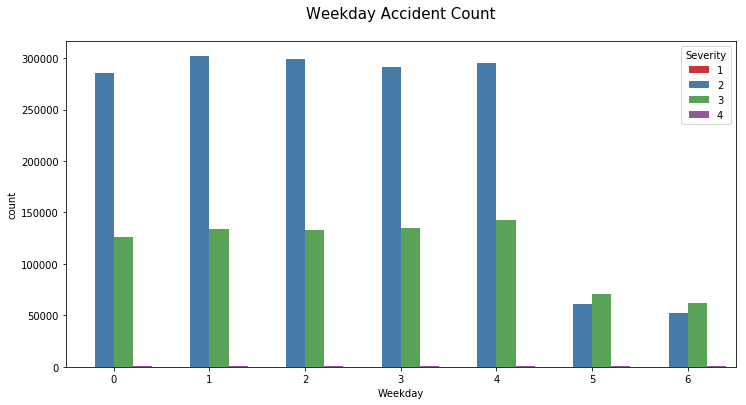

In [78]:
plt.figure(figsize = (12,6))
sns.countplot(x = 'Weekday', hue = 'Severity', data = df ,palette = "Set1")
plt.title('Weekday Accident Count', size = 15, y = 1.05)
plt.show()

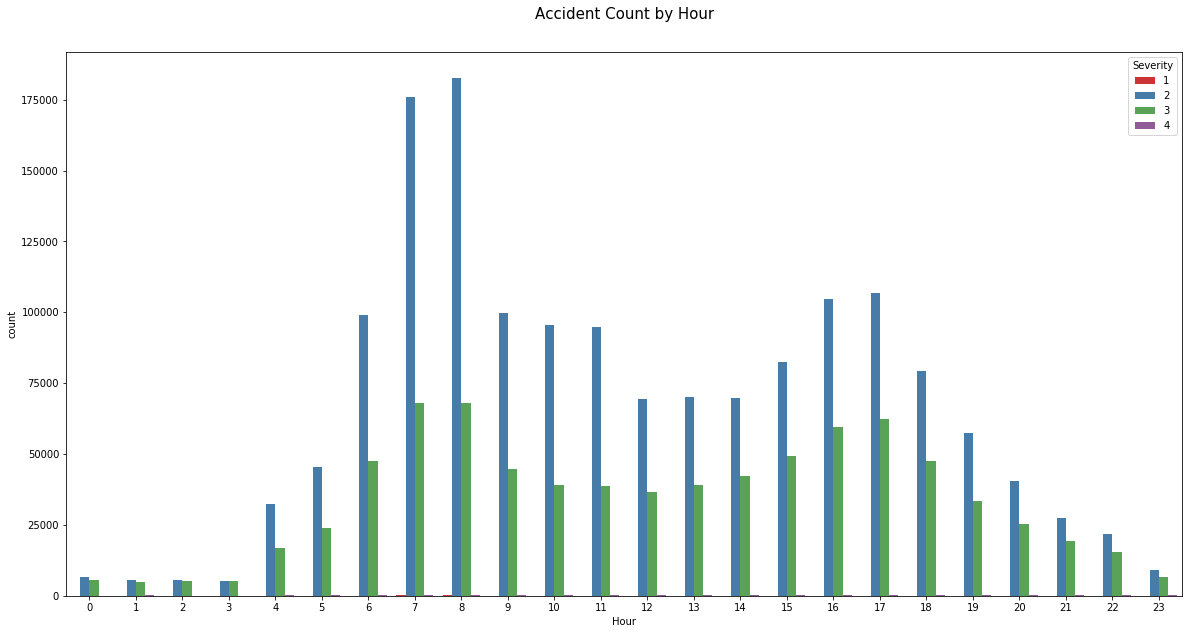

In [79]:
plt.figure(figsize = (20,10))
sns.countplot(x = 'Hour', hue = 'Severity', data = df ,palette = "Set1")
plt.title('Accident Count by Hour', size = 15, y = 1.05)
plt.show()

,Severity 1,Severity 2,Severity 3,Severity 4,Total
Clear,353,429080,221127,538,651098
Mostly Cloudy,146,221223,117429,967,339765
Fair,105,220397,79931,2158,302591
Overcast,114,189048,101176,230,290568
Partly Cloudy,105,155817,79821,613,236356
Scattered Clouds,73,99093,55995,142,155303
Cloudy,36,87406,35647,868,123957
Light Rain,45,74397,45106,437,119985
Light Snow,10,18624,13942,130,32706
Rain,12,15967,11727,102,27808


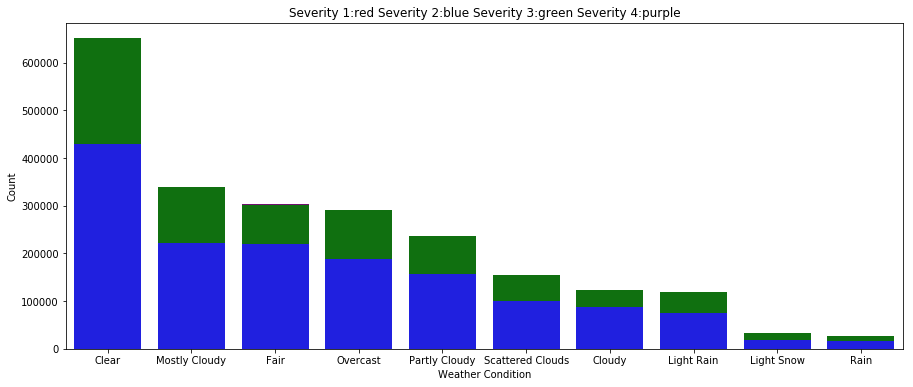

In [80]:
weather_types, weather_details = visualize_severity_detailed(df, column_name = 'Weather_Condition')
ntop = 10
fig = plt.figure(figsize = (15,6))
sns.barplot(weather_types[:ntop], weather_details['Severity 1'][:ntop], color = "red")
sns.barplot(weather_types[:ntop], weather_details['Severity 2'][:ntop], bottom = weather_details["Severity 1"][:ntop], color = "blue")
sns.barplot(weather_types[:ntop], weather_details['Severity 3'][:ntop], bottom = weather_details["Severity 2"][:ntop] + weather_details["Severity 1"][:ntop],color = "green")
sns.barplot(weather_types[:ntop], weather_details['Severity 4'][:ntop], bottom = weather_details["Severity 3"][:ntop] + weather_details["Severity 2"][:ntop] + weather_details["Severity 1"][:ntop],color = "purple")
plt.title("Severity 1:red Severity 2:blue Severity 3:green Severity 4:purple")
plt.xlabel('Weather Condition')
plt.ylabel("Count")
plt.show()

In [81]:
labels = {}
flag = 1
for arg in weather_types:
    labels[arg] = flag
    flag = flag + 1

label_vals = [labels[arg] for arg in df['Weather_Condition']]
df['Weather_Condition'] = label_vals

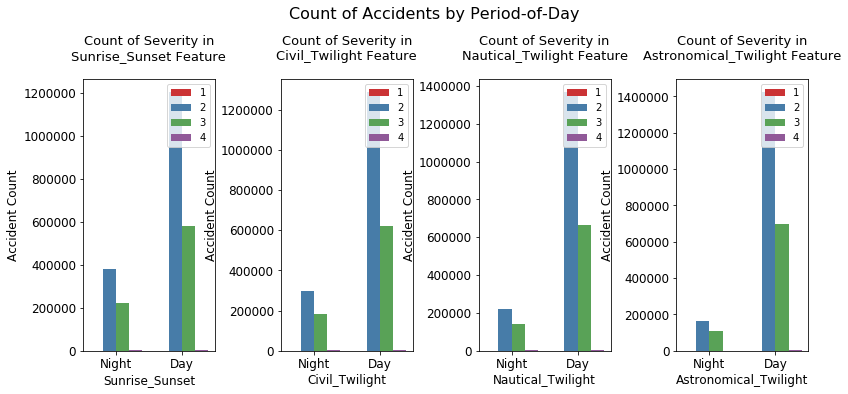

In [82]:
period_features = ['Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']
fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(13, 5))

plt.subplots_adjust(wspace = 0.5)
for i, feature in enumerate(period_features, 1):    
    plt.subplot(1, 4, i)
    sns.countplot(x=feature, hue='Severity', data = df ,palette="Set1")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(['1', '2', '3', '4'], loc='upper right', prop={'size': 10})
    plt.title('Count of Severity in\n{} Feature'.format(feature), size=13, y=1.05)
fig.suptitle('Count of Accidents by Period-of-Day',y=1.08, fontsize=16)
plt.show()

In [83]:
print("Sunrise_Sunset Details")
ntop=df["Sunrise_Sunset"].nunique()
df["Sunrise_Sunset"]=df["Sunrise_Sunset"].fillna('Day')
sunrise_types,sunrise_details=visualize_severity_detailed(df,column_name="Sunrise_Sunset")

Sunrise_Sunset Details


,Severity 1,Severity 2,Severity 3,Severity 4,Total
Day,769,1204861,580074,4141,1789845
Night,274,381553,224362,2515,608704


In [84]:
labels = {}
flag = 1
for arg in sunrise_types:
    labels[arg] = flag
    flag = flag + 1
print(labels)

label_vals = [labels[arg] for arg in df['Sunrise_Sunset']]
df['Sunrise_Sunset'] = label_vals

{'Day': 1, 'Night': 2}


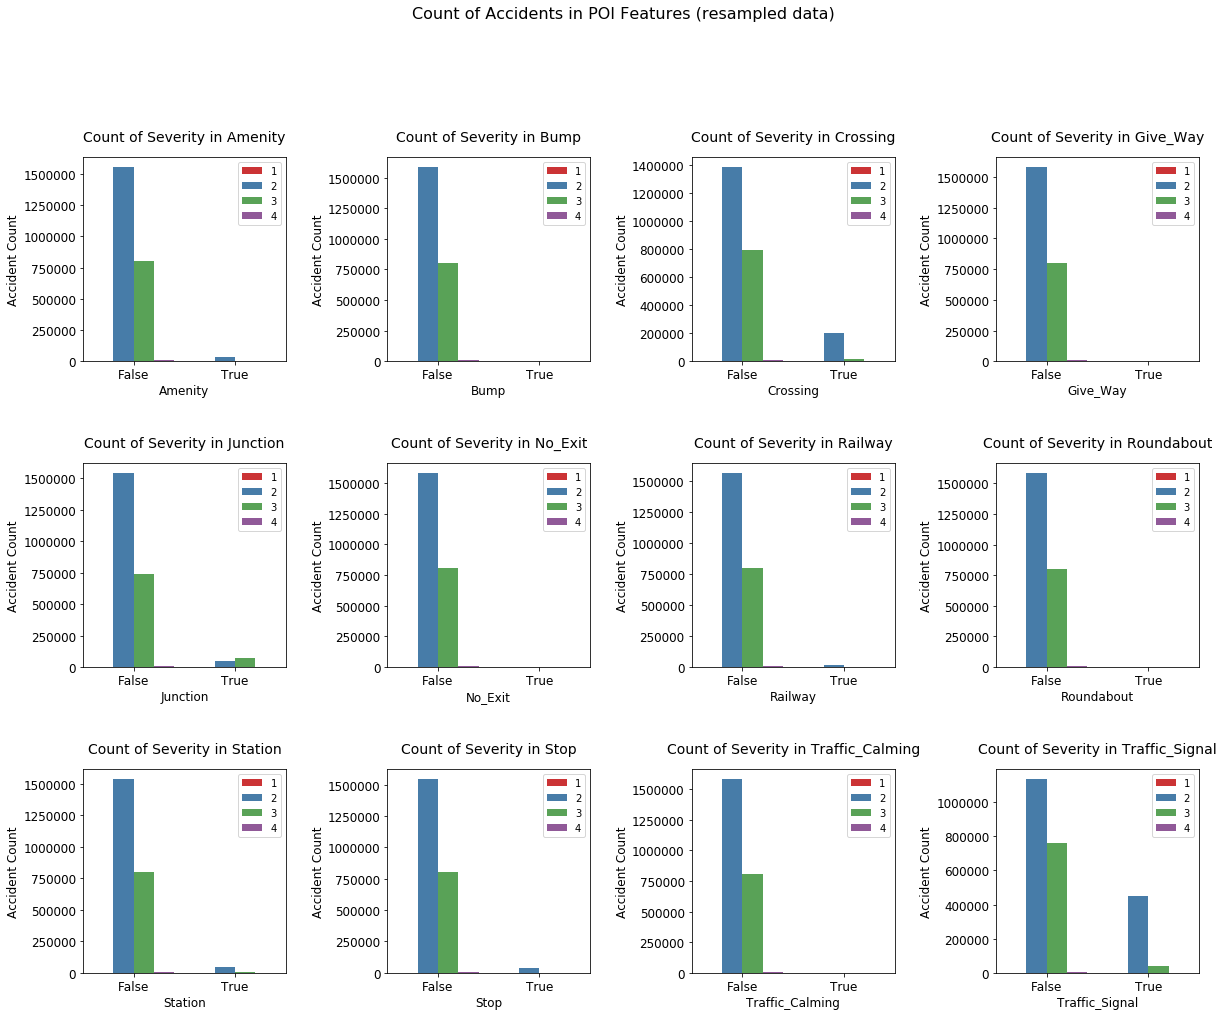

In [85]:
POI_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(20, 15))

plt.subplots_adjust(hspace=0.5,wspace = 0.5)
for i, feature in enumerate(POI_features, 1):    
    plt.subplot(3, 4, i)
    sns.countplot(x=feature, hue='Severity', data=df ,palette="Set1")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis = 'x', labelsize=12)
    plt.tick_params(axis = 'y', labelsize=12)
    
    plt.legend(['1', '2', '3','4'], loc = 'upper right', prop = {'size': 10})
    plt.title('Count of Severity in {}'.format(feature), size = 14, y=1.05)
fig.suptitle('Count of Accidents in POI Features (resampled data)',y=1.02, fontsize=16)
plt.show()

In [86]:
df[POI_features] = df[POI_features].astype('category')
df = pd.get_dummies(df, columns = POI_features, drop_first = True)

In [87]:
side_types=df['Side'].unique()
labels={}
flag=1
for arg in side_types:
    labels[arg]=flag
    flag=flag+1
print(labels)

label_vals=[labels[arg] for arg in df['Side']]
df['Side']=label_vals

{'R': 1, 'L': 2, ' ': 3}


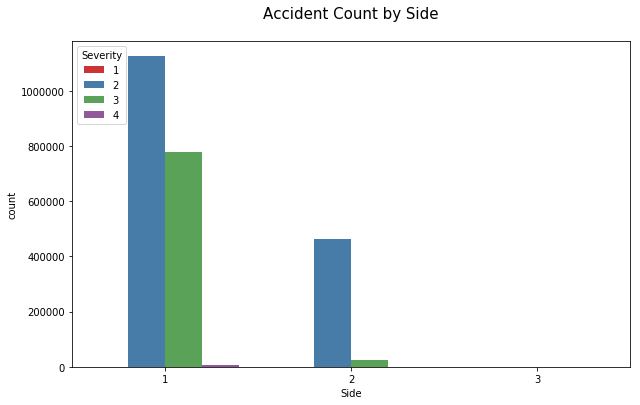

In [88]:
plt.figure(figsize = (10,6))
chart = sns.countplot(x = 'Side', hue = 'Severity', data = df ,palette = "Set1")
plt.title("Accident Count by Side", size=15, y=1.05)
plt.show()

In [89]:
df = df.drop(['Start_Time','Timezone','Airport_Code','Minute', 'Civil_Twilight', 'Day', 'Astronomical_Twilight', 'Nautical_Twilight', 'Weekday'], axis = 1)

In [90]:
state_lst = ['NJ','NY']
state_lst_full = ['New Jersey','New York']
df_states = df[df.State.isin(state_lst)]
df_states.head()

,Severity,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Temperature(F),...,Crossing_True,Give_Way_True,Junction_True,No_Exit_True,Railway_True,Roundabout_True,Station_True,Stop_True,Traffic_Calming_True,Traffic_Signal_True
194254,2,40.775616,-74.237305,Main St,2,Orange,Essex,NJ,07050-1520,55.0,...,0,0,0,0,0,0,0,0,0,1
194255,3,41.139324,-74.169876,Route 17,1,Sloatsburg,Rockland,NY,10974,53.1,...,0,0,0,0,0,0,0,0,0,0
194256,3,41.118748,-74.159744,I-287 S,1,Suffern,Rockland,NY,10901,53.1,...,0,0,0,0,0,0,0,0,0,0
194257,3,41.014034,-73.717239,Hutchinson River Pkwy S,1,White Plains,Westchester,NY,10605,52.0,...,0,0,1,0,0,0,0,0,0,0
194258,3,41.390369,-73.597969,I-84 E,1,Brewster,Putnam,NY,10509,52.0,...,0,0,0,0,0,0,0,0,0,0


In [91]:
severity_count = {}
severity_count[1] = df_states[df_states["Severity"] == 1].shape[0]
severity_count[2] = df_states[df_states["Severity"] == 2].shape[0]
severity_count[3] = df_states[df_states["Severity"] == 3].shape[0]
severity_count[4] = df_states[df_states["Severity"] == 4].shape[0]

frame = pd.DataFrame(severity_count,index = ["Severity"])
print("Severity in New York and New Jersey")
display(frame)

Severity in New York and New Jersey


,1,2,3,4
Severity,48,93373,58699,232


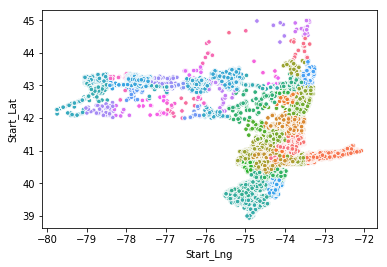

In [92]:
sns.scatterplot(x = 'Start_Lng', y = 'Start_Lat', data = df_states, hue = 'County', legend=False, s=20)
plt.show()

[]

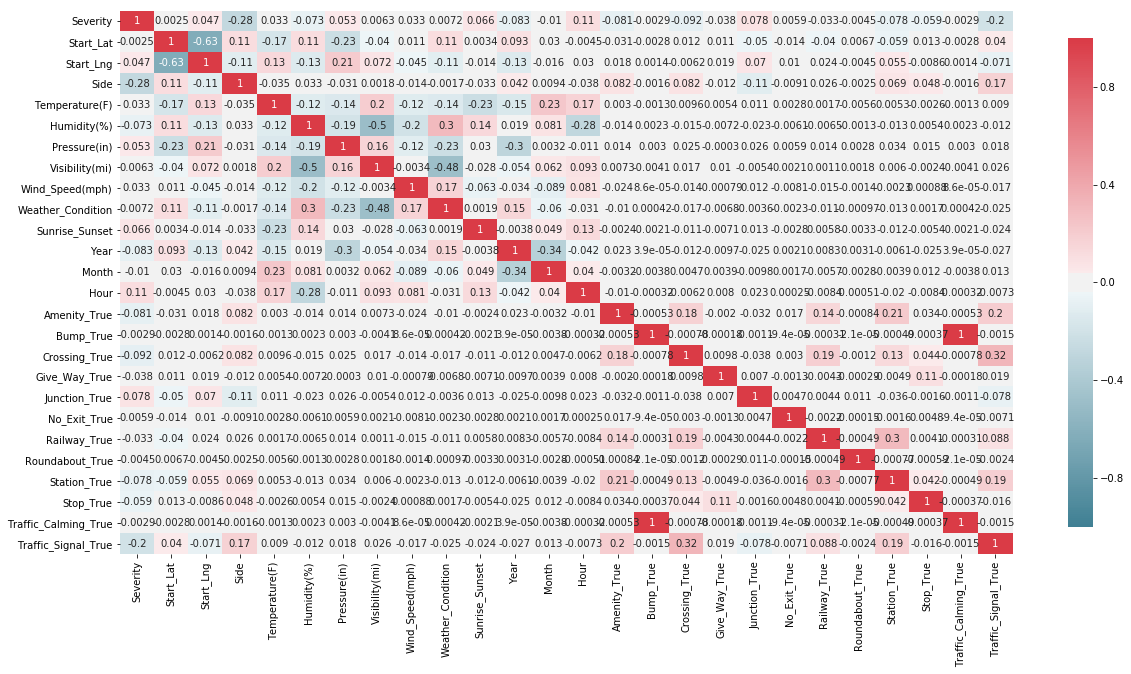

In [93]:
corr=df_states.corr()

f, ax = plt.subplots(figsize = (20, 10))
g = sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = False, ax = ax, annot = True, vmax = 1.0, vmin = -1.0, cbar_kws = {"shrink": 0.9})
g.set_yticklabels(g.get_yticklabels(), rotation = 0)
plt.plot()

In [94]:
df_states.head()

,Severity,Start_Lat,Start_Lng,Street,Side,City,County,State,Zipcode,Temperature(F),...,Crossing_True,Give_Way_True,Junction_True,No_Exit_True,Railway_True,Roundabout_True,Station_True,Stop_True,Traffic_Calming_True,Traffic_Signal_True
194254,2,40.775616,-74.237305,Main St,2,Orange,Essex,NJ,07050-1520,55.0,...,0,0,0,0,0,0,0,0,0,1
194255,3,41.139324,-74.169876,Route 17,1,Sloatsburg,Rockland,NY,10974,53.1,...,0,0,0,0,0,0,0,0,0,0
194256,3,41.118748,-74.159744,I-287 S,1,Suffern,Rockland,NY,10901,53.1,...,0,0,0,0,0,0,0,0,0,0
194257,3,41.014034,-73.717239,Hutchinson River Pkwy S,1,White Plains,Westchester,NY,10605,52.0,...,0,0,1,0,0,0,0,0,0,0
194258,3,41.390369,-73.597969,I-84 E,1,Brewster,Putnam,NY,10509,52.0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
df_states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152352 entries, 194254 to 2476575
Data columns (total 31 columns):
Severity                152352 non-null int64
Start_Lat               152352 non-null float64
Start_Lng               152352 non-null float64
Street                  152352 non-null object
Side                    152352 non-null int64
City                    152352 non-null object
County                  152352 non-null object
State                   152352 non-null object
Zipcode                 152352 non-null object
Temperature(F)          152352 non-null float64
Humidity(%)             152352 non-null float64
Pressure(in)            152352 non-null float64
Visibility(mi)          152352 non-null float64
Wind_Speed(mph)         152352 non-null float64
Weather_Condition       152352 non-null int64
Sunrise_Sunset          152352 non-null int64
Year                    152352 non-null int64
Month                   152352 non-null int64
Hour                    152352 non-n

In [98]:
x_clmns = list(df.columns)
x_clmns.remove('Severity')
x_clmns.remove('Street')
x_clmns.remove('City')
x_clmns.remove('County')
x_clmns.remove('State')
x_clmns.remove('Zipcode')
y_clmns = ["Severity"]

X = df_states[x_clmns].values
y = df_states[y_clmns].values

y = np.reshape(y,(-1,1))
y = y[:,]

X_train, X_test, y_train, y_test = train_test_split(X,y[:,0], test_size = 0.1,random_state = 42)

print("Train size:",X_train.shape[0])
print("Test size:",X_test.shape[0])

severity_count_y_test = {}
severity_count_y_test[1] = y_test[y_test == 1].shape[0]
severity_count_y_test[2] = y_test[y_test == 2].shape[0]
severity_count_y_test[3] = y_test[y_test == 3].shape[0]
severity_count_y_test[4] = y_test[y_test == 4].shape[0]

frame = pd.DataFrame(severity_count_y_test,index = ["Severity count in Test Data"])
display(frame)

Train size: 137116
Test size: 15236


,1,2,3,4
Severity count in Test Data,5,9341,5865,25


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy of train data: 0.6527903381078795
Accuracy of test data: 0.6514833289577316


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


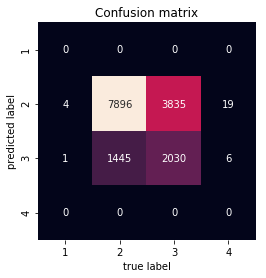

,1,2,3,4
Severity.count in test_data,5,9341,5865,25


In [99]:
lr = LogisticRegression(random_state=0,solver='saga',max_iter=1000)
lr.fit(X_train,y_train)

y_pred=lr.predict(X_train)
acc_train_lr=accuracy_score(y_train, y_pred)
print("Accuracy of train data:",acc_train_lr)

y_pred=lr.predict(X_test)
acc_test_lr=accuracy_score(y_test, y_pred)
print("Accuracy of test data:",acc_test_lr)

mat_lr = confusion_matrix(y_pred,y_test)
sns.heatmap(mat_lr, square=True, annot=True, fmt='d', cbar=False,xticklabels=[1,2,3,4],yticklabels=[1,2,3,4])
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title("Confusion matrix")
plt.show()

frame=pd.DataFrame(severity_count_y_test,index=["Severity.count in test_data"])
display(frame)

k= 1  Train Accuracy: 0.9994821902622597 Test accuracy: 0.6182725124704647
k= 2  Train Accuracy: 0.8149887686338575 Test accuracy: 0.636190601207666
k= 3  Train Accuracy: 0.8019560080515767 Test accuracy: 0.618994486741927
k= 4  Train Accuracy: 0.754565477405992 Test accuracy: 0.6317274875295353
k= 5  Train Accuracy: 0.7507803611540593 Test accuracy: 0.6169598319768969
k= 6  Train Accuracy: 0.7268152513200502 Test accuracy: 0.6298241008138619
k= 7  Train Accuracy: 0.7240657545435981 Test accuracy: 0.6172223680756104
k= 8  Train Accuracy: 0.7085314624113889 Test accuracy: 0.6279863481228669
k= 9  Train Accuracy: 0.7077948598267161 Test accuracy: 0.6222761879758467


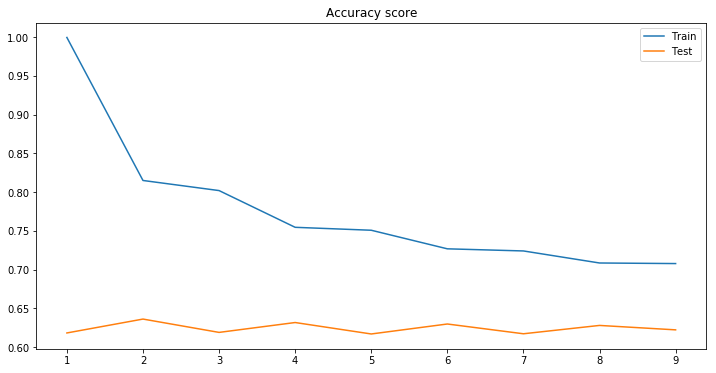

,1,2,3,4
Severity.count in Test Data,5,9341,5865,25


In [100]:
train_accuracy = []
test_accuracy = []
k_array = range(1,10)

for i in k_array:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)

    y_pred = knn.predict(X_train)
    acc=accuracy_score(y_train, y_pred)
    train_accuracy.append(acc)

    y_pred = knn.predict(X_test)
    acc=accuracy_score(y_test, y_pred)
    test_accuracy.append(acc)

    print("k=",i," Train Accuracy:",train_accuracy[-1],"Test accuracy:",test_accuracy[-1])

plt.figure(figsize = (12,6))
plt.plot(k_array,train_accuracy)
plt.plot(k_array,test_accuracy)
plt.legend(['Train','Test'])
plt.title('Accuracy score')
plt.show()

frame = pd.DataFrame(severity_count_y_test,index=['Severity.count in Test Data'])
display(frame)

,1,2,3,4
Severity count in test_data,5,9341,5865,25


,Train,Test
Logistic,0.652790,0.651483
KNN,0.754565,0.631727


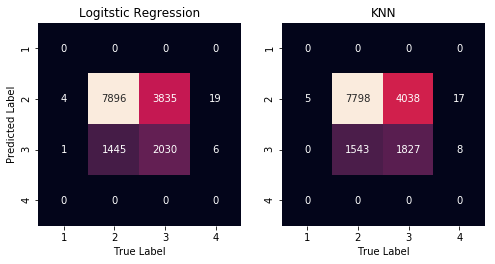

In [101]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train,y_train)

y_pred = knn.predict(X_train)
acc_train_knn = accuracy_score(y_train, y_pred)

y_pred = knn.predict(X_test)
acc_test_knn = accuracy_score(y_test, y_pred)

mat_knn = confusion_matrix(y_pred,y_test)

frame = pd.DataFrame(severity_count_y_test,index = ["Severity count in test_data"])
display(frame)

frame = pd.DataFrame({"Train":[acc_train_lr,acc_train_knn],
                    "Test":[acc_test_lr,acc_test_knn]},
                   index = ["Logistic","KNN"])
display(frame)

plt.figure(figsize=(8,4))

plt.subplot(121)
sns.heatmap(mat_lr, square = True, annot = True, fmt='d', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Logitstic Regression')

plt.subplot(122)
sns.heatmap(mat_knn, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.title('KNN')

plt.show()


,1,2,3,4
Severity count in Test Data,5,9341,5865,25


,Train,Test
Logistic,0.652790,0.651483
KNN,0.754565,0.631727
Decision Tree,0.865924,0.768903


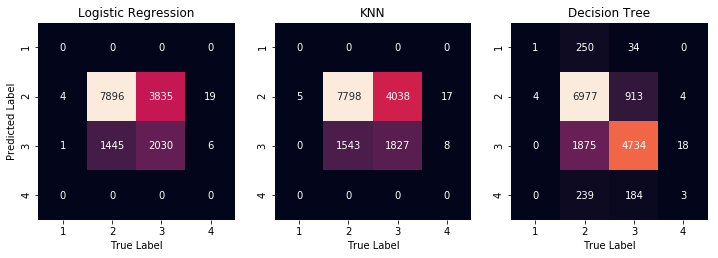

In [103]:
tree = DecisionTreeClassifier(max_depth = 20,class_weight = 'balanced')
tree.fit(X_train, y_train)

y_pred = tree.predict(X_train)
acc_train_dt = accuracy_score(y_train, y_pred)

y_pred = tree.predict(X_test)
acc_test_dt = accuracy_score(y_pred,y_test)
mat_dt = confusion_matrix(y_pred,y_test)

frame = pd.DataFrame(severity_count_y_test,index = ['Severity count in Test Data'])
display(frame)

frame = pd.DataFrame({"Train":[acc_train_lr,acc_train_knn,acc_train_dt],
                    "Test":[acc_test_lr,acc_test_knn,acc_test_dt]},
                   index = ['Logistic', 'KNN', 'Decision Tree'])
display(frame)

plt.figure(figsize = (12,5))

plt.subplot(131)
sns.heatmap(mat_lr, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Logistic Regression')

plt.subplot(132)
sns.heatmap(mat_knn, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.title('KNN')

plt.subplot(133)
sns.heatmap(mat_dt, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.title('Decision Tree')

plt.show()


,1,2,3,4
Severity count in Test Data,5,9341,5865,25


,Train,Test
Logistic,0.652790,0.651483
KNN,0.754565,0.631727
Decision Tree,0.865924,0.768903
Random Forest,0.999482,0.831911


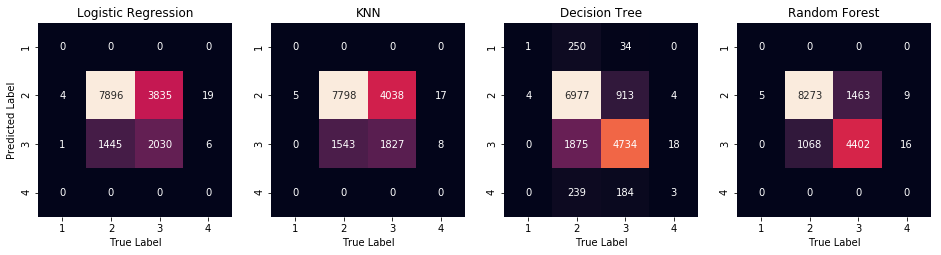

,1,2,3,4
Severity.count in Test Data,5,9341,5865,25


In [107]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 100,class_weight = 'balanced')
RF.fit(X_train, y_train)

y_pred = RF.predict(X_train)
acc_train_RF = accuracy_score(y_train, y_pred)

y_pred = RF.predict(X_test)
acc_test_RF = accuracy_score(y_pred,y_test)
mat_RF = confusion_matrix(y_pred,y_test)

frame=pd.DataFrame(severity_count_y_test,index = ["Severity count in Test Data"])
display(frame)

frame = pd.DataFrame({"Train":[acc_train_lr,acc_train_knn,acc_train_dt,acc_train_RF],
                    "Test":[acc_test_lr,acc_test_knn,acc_test_dt,acc_test_RF]},
                   index = ["Logistic","KNN","Decision Tree","Random Forest"])
display(frame)

plt.figure(figsize = (16,6))

plt.subplot(141)
sns.heatmap(mat_lr, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Logistic Regression')

plt.subplot(142)
sns.heatmap(mat_knn, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.title('KNN')

plt.subplot(143)
sns.heatmap(mat_dt, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.title('Decision Tree')

plt.subplot(144)
sns.heatmap(mat_RF, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [1,2,3,4],yticklabels = [1,2,3,4])
plt.xlabel('True Label')
plt.title('Random Forest')

plt.show()

frame = pd.DataFrame(severity_count_y_test,index = ["Severity.count in Test Data"])
display(frame)

In [114]:
req_data=df_states
severity_count={}
severity_count[1]=req_data[req_data["Severity"]==1].shape[0]
severity_count[2]=req_data[req_data["Severity"]==2].shape[0]
severity_count[3]=req_data[req_data["Severity"]==3].shape[0]
severity_count[4]=req_data[req_data["Severity"]==4].shape[0]
tot_count=severity_count[1]+severity_count[2]+severity_count[3]+severity_count[4]


frame=pd.DataFrame(severity_count,index=["Severity Count"])
display(frame)

severity_count={}
severity_count[1]=req_data[req_data["Severity"]==1].shape[0]/tot_count*100
severity_count[2]=req_data[req_data["Severity"]==2].shape[0]/tot_count*100
severity_count[3]=req_data[req_data["Severity"]==3].shape[0]/tot_count*100
severity_count[4]=req_data[req_data["Severity"]==4].shape[0]/tot_count*100

frame=pd.DataFrame(severity_count,index=["Severity percentage"])
display(frame)

print("Removing outliers")
req_data=req_data[~(req_data["Severity"]==1)]
req_data=req_data[~(req_data["Severity"]==4)]

severity_count={}
severity_count[1]=req_data[req_data["Severity"]==1].shape[0]
severity_count[2]=req_data[req_data["Severity"]==2].shape[0]
severity_count[3]=req_data[req_data["Severity"]==3].shape[0]
severity_count[4]=req_data[req_data["Severity"]==4].shape[0]

frame=pd.DataFrame(severity_count,index=["Severity count"])
display(frame)

,1,2,3,4
Severity Count,48,93373,58699,232


,1,2,3,4
Severity percentage,0.031506,61.287676,38.528539,0.152279


Removing outliers


,1,2,3,4
Severity count,0,93373,58699,0


In [115]:
x_clmns = list(df.columns)
x_clmns.remove('Severity')
x_clmns.remove('Street')
x_clmns.remove('City')
x_clmns.remove('County')
x_clmns.remove('State')
x_clmns.remove('Zipcode')
y_clmns = ['Severity']

X=req_data[x_clmns].values
y=req_data[y_clmns].values

y=np.reshape(y,(-1,1))
y=y[:,]

X_train, X_test, y_train, y_test = train_test_split(X,y[:,0], test_size=0.1,random_state=21)

print("Train size:",X_train.shape[0])
print("Test size:",X_test.shape[0])

severity_count_y_test_no_outliers={}
severity_count_y_test_no_outliers[1]=y_test[y_test==1].shape[0]
severity_count_y_test_no_outliers[2]=y_test[y_test==2].shape[0]
severity_count_y_test_no_outliers[3]=y_test[y_test==3].shape[0]
severity_count_y_test_no_outliers[4]=y_test[y_test==4].shape[0]

frame = pd.DataFrame(severity_count_y_test_no_outliers,index = ["Severity count in Test Data"])
display(frame)

Train size: 136864
Test size: 15208


,1,2,3,4
Severity count in Test Data,0,9247,5961,0


,1,2,3,4
Severity count in Test Data,0,9247,5961,0


,Train,Test
Logistic,0.652790,0.651483
KNN,0.754565,0.631727
Decision Tree,0.865924,0.768903
Random Forest,0.999482,0.831911
Decision Tree sans outliers,0.940700,0.883154


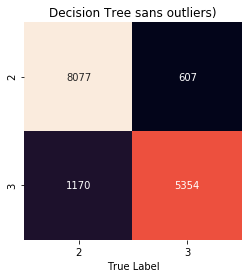

In [118]:
tree = DecisionTreeClassifier(max_depth = 20,class_weight = 'balanced')
tree.fit(X_train, y_train)

y_pred = tree.predict(X_train)
acc_train_dt_no_outliers = accuracy_score(y_train, y_pred)

y_pred = tree.predict(X_test)
acc_test_dt_no_outliers = accuracy_score(y_pred,y_test)
mat_dt_no_outliers = confusion_matrix(y_pred,y_test)

frame=pd.DataFrame(severity_count_y_test_no_outliers,index=["Severity count in Test Data"])
display(frame)

frame=pd.DataFrame({"Train":[acc_train_lr,acc_train_knn,acc_train_dt,acc_train_RF,acc_train_dt_no_outliers],
                    "Test":[acc_test_lr,acc_test_knn,acc_test_dt,acc_test_RF,acc_test_dt_no_outliers]},
                   index = ['Logistic','KNN','Decision Tree','Random Forest','Decision Tree sans outliers'])
display(frame)

plt.figure(figsize = (4,4))
sns.heatmap(mat_dt_no_outliers, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [2,3],yticklabels = [2,3])
plt.xlabel('True Label')
plt.title('Decision Tree sans outliers)')
plt.show()

,1,2,3,4
Severity count in Test Data,0,9247,5961,0


,Train,Test
Logistic,0.652790,0.651483
KNN,0.754565,0.631727
Decision Tree,0.865924,0.768903
Random Forest,0.999482,0.831911
Decision Tree sans outliers,0.940700,0.883154
Random Forest sans outliers,0.999415,0.855865


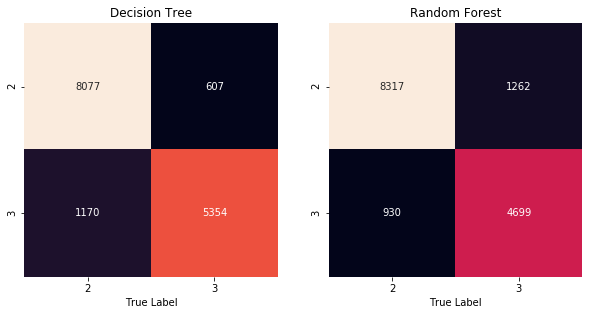

In [119]:
RF = RandomForestClassifier(n_estimators = 100,class_weight = 'balanced')
RF.fit(X_train, y_train)

y_pred = RF.predict(X_train)
acc_train_RF_outliers = accuracy_score(y_train, y_pred)

y_pred = RF.predict(X_test)
acc_test_RF_outliers = accuracy_score(y_pred,y_test)
mat_rf_no_outliers = confusion_matrix(y_pred,y_test)

frame = pd.DataFrame(severity_count_y_test_no_outliers,index = ['Severity count in Test Data'])
display(frame)

frame = pd.DataFrame({'Train':[acc_train_lr,acc_train_knn,acc_train_dt,acc_train_RF,acc_train_dt_no_outliers,acc_train_RF_outliers],
                    'Test':[acc_test_lr,acc_test_knn,acc_test_dt,acc_test_RF,acc_test_dt_no_outliers,acc_test_RF_outliers]},
                   index = ['Logistic','KNN','Decision Tree','Random Forest','Decision Tree sans outliers','Random Forest sans outliers'])
display(frame)

plt.figure(figsize = (10,5))
plt.subplot(121)
sns.heatmap(mat_dt_no_outliers, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [2,3],yticklabels = [2,3])
plt.xlabel('True Label')
plt.title('Decision Tree')

plt.subplot(122)
sns.heatmap(mat_rf_no_outliers, square = True, annot = True, fmt = 'd', cbar = False,xticklabels = [2,3],yticklabels = [2,3])
plt.xlabel('True Label')
plt.title('Random Forest')

plt.show()